Optimality with Dynamic Motion Primitives in Obstacle Scenarios
====

read successfully..
5.544444561000001


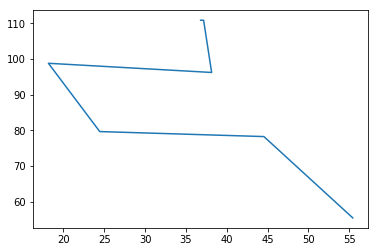

In [13]:
# libraries for loading the recorded trajectory and plotting

import matplotlib.pyplot as plt
from utils import get_trajectory

# the trajectory has been recorded in the ROS turtlesim by using the keyboard teleop interface and converted to a csv
# file from a rosbag file.

x, y = get_trajectory("../csv/data.csv")

# Scaling (Done so as to keep the resolution of the grid edge smaller than the distance to consecutive points of 
# the DMP)
x = [10 * i for i in x]
y = [10 * j for j in y]

plt.plot(x, y)
plt.show()

Path Imitation using DMP
----

In [17]:
from dmp_discrete import DMPs_discrete
import numpy as np

# specify the number of basis functions in n_bfs, time resolution as dt and total run time.
dmp = DMPs_discrete(n_dmps=2, n_bfs=100, dt=0.01, run_time=1.0)

# learn the weights for the basis functions
dmp.imitate_path(y_des=np.array([x, y]))
print("weights generated for the DMP")

weights generated for the DMP


Specify the start and goal positions for the rollout. In this example, we try to just use the same start and goal positions as in the demonstration.

In [18]:
dmp.y0[0] = x[0]
dmp.y0[1] = y[0]

dmp.goal[0] = x[-1]
dmp.goal[1] = y[-1]

y_track_nc, dy_track_nc, ddy_track_nc, s = dmp.rollout()

For plotting the rolled out trajectory, execute the cell below.

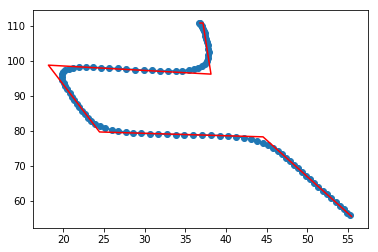

In [19]:
plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])
plt.plot(x, y, color='r')

DMPs with Variable Start and Goal
---

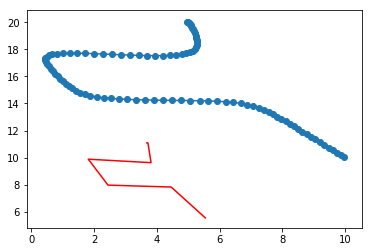

In [8]:
dmp.y0[0] = 10.0
dmp.y0[1] = 10.0

dmp.goal[0] = 5.0
dmp.goal[1] = 20.0

y_track2, dy_track2, ddy_track2, s2 = dmp.rollout()

plt.plot(y_track2[:, 0], y_track2[:, 1])
plt.scatter(y_track2[:, 0], y_track2[:, 1])
plt.plot(x, y, color='r')

Obstacle Worlds
---

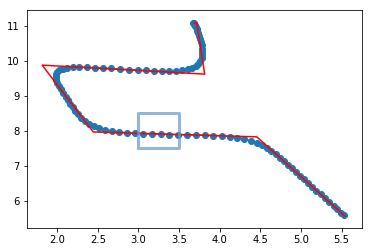

In [5]:
import math
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point, mapping
from math import sqrt, ceil, floor

# specify the end points of the polygon.
coords = [(3.0, 7.5), (3.0, 8.5), (3.5, 8.5), (3.5, 7.5)]

obstacle = Polygon(coords)
ob_x, ob_y = obstacle.exterior.xy
plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])
plt.plot(x, y, color='r')
plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)


As you can see, since the demonstration was for an obstacle free scenario, the path rolled out by the DMP is not able to adapt to the obstacle that is present in the environment. Therefore, for making this adapt to the obstacle scenario, we try out various approaches: (1). Potential fields (2). Grid Search (3). Probabilistic Roadmaps (4). Time-Space Probabilistic Roadmap

Potential Field Methods
---

We first try out a potential field method. A point repulsive field is applied throughout the rolled out trajectory. The point repulsive field for a given point on the DMP, is the closest point on the obstacle to the DMP.

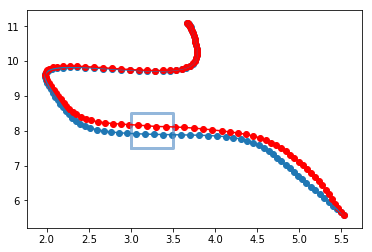

In [6]:
from utils import avoid_obstacles

y_track_pot, dy_track_pot, ddy_track_pot, s = dmp.rollout(obstacles=[obstacle], external_force=avoid_obstacles)


plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

plt.plot(y_track_pot[:, 0], y_track_pot[:, 1], color='r')
plt.scatter(y_track_pot[:, 0], y_track_pot[:, 1], color='r')

Grid Search Based Methods
---

Above we can see that the obstacle field is not able to make the path feasible. The approach requires tuning hyperparamters such as the strength of the field. For many scenarios the approach might work but it provides no gurantee of feasibility and optimality. However, it is computationally cheaper than some of the other approaches that would be discussed later.

Now, we try out a Grid based Method, which gives a gurantee of finding a feasible solution if one exists given a small enough grid resolution. The edge weight is defined as the 2D euclidean distance of the grid point from the nearest point on the DMP, which serves as a guiding path. 

Once a graph is constructed from the grid points, a graph search algorithm is used to return the lowest cost path.

In [ ]:
def dijkstra_planning(sx, sy, gx, gy, obstacles, reso, cost_type="default", dmp=None,
                      dmp_vel=None, dt=0.01):
    """
    :param sx: start x coordinate
    :param sy: start y coordinate
    :param gx: goal x coordinate
    :param gy: goal y coordinate
    :param obstacles: list of shapely polygons
    :param reso: resolution of smaller grids
    :param cost_type: type of cost defining edge weights
    :param dmp: path given by a dmp
    :param dmp_vel: dmp_velocities
    :param dt: time resolution of the dmp
    :return: time parameterised path

    """

    # scale the dmp and its velocities according to the resolution of the grid.

    if cost_type == "dmp_traj":
        print("shape of dmp is: ", dmp.shape)
        print("shape of dmp velocity is: ", dmp_vel.shape)
        for i in range(0, len(dmp)):
            for j in range(0, len(dmp[i])):
                dmp[i][j] = dmp[i][j] / reso
                dmp_vel[i][j] = dmp[i][j] / reso

    nstart = Node(round(sx / reso), round(sy / reso), 0.0, -1)

    if cost_type == "dmp_traj":
        ngoal = Node(round(gx / reso), round(gy / reso), 0.0, -1, len(dmp))

    else:
        ngoal = Node(round(gx / reso), round(gy / reso), 0.0, -1)

    obmap, minx, miny, maxx, maxy, xw, yw = calc_obstacle_map(obstacles, reso)

    motion = get_motion_model()

    openset, closedset = dict(), dict()
    openset[calc_index(nstart, xw, minx, miny)] = nstart

    while 1:
        c_id = min(openset, key=lambda o: openset[o].cost)
        current = openset[c_id]
        # show graph
        if show_animation:
            plt.plot(current.x * reso, current.y * reso, "xc")
            if len(closedset.keys()) % 10 == 0:
                plt.pause(0.1)

        if current.x == ngoal.x and current.y == ngoal.y:
            print("[INFO]: searched reached the goal")
            ngoal.pind = current.pind
            ngoal.cost = current.cost
            break

        # Remove the item from the open set
        del openset[c_id]
        # Add it to the closed set
        closedset[c_id] = current

        # expand search grid based on motion model
        for i, _ in enumerate(motion):
            if cost_type == "default":
                node = Node(current.x + motion[i][0], current.y + motion[i][1],
                            current.cost + motion[i][2], c_id)
            elif cost_type == "dmp_traj":
                dmp_cost = calculate_dmp_cost(current.x, current.y,
                                              motion[i][0], motion[i][1],
                                              dmp, dmp_vel, obstacles, reso, dt)
                node = Node(current.x + motion[i][0], current.y + motion[i][1],
                            current.cost + dmp_cost,
                            c_id)

            n_id = calc_index(node, xw, minx, miny)

            if not verify_node(node, obmap, minx, miny, maxx, maxy):
                continue

            if n_id in closedset:
                continue
            # Otherwise if it is already in the open set
            if n_id in openset:
                # print("nid exists in openset")
                if openset[n_id].cost > node.cost:
                    openset[n_id].cost = node.cost
                    openset[n_id].pind = c_id

            else:
                openset[n_id] = node

    rx, ry = calc_final_path(ngoal, closedset, reso)

    return rx, ry
